In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn  
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Prep

In [2]:
def get_windows(x,window_size,stride):
    max_idx = len(x[:-window_size])
    window_list = []
    for idx in np.arange(0,max_idx,step=stride):
        window_list.append(x[idx:idx+window_size])
    return window_list

def data_prep(path,window_size,stride):

    data_pd = pd.read_csv(path)

    data_pd['genre_coded'] = data_pd['genre'].astype('category').cat.codes

    sensor_cols = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','mag_x','mag_y','mag_z']

    scaled_pd = []
    for id in data_pd['subject_id'].unique():
        filtered_pd = data_pd[data_pd['subject_id']==id]
        for col in sensor_cols:
            scaler = StandardScaler()
            col_scaled = scaler.fit_transform(filtered_pd[col].values.reshape(-1,1))
            filtered_pd[col] = col_scaled.reshape(-1)
        scaled_pd.append(filtered_pd)

    scaled_pd = pd.concat(scaled_pd)

    data_list = scaled_pd.groupby(['subject_id','label','genre_coded'])[sensor_cols].agg(list).reset_index()

    for col in sensor_cols:
        data_list[col] = data_list[col].apply(lambda x: get_windows(x,window_size,stride))

    data_list = data_list.explode(sensor_cols)

    return data_list

In [3]:
class CreateDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_tensor = torch.tensor(self.data.iloc[idx,3:].tolist(),dtype=torch.float).transpose(0,1).unsqueeze(0)
        label = torch.tensor(self.data.iloc[idx,2],dtype=torch.long)
        return input_tensor.to(device), label.to(device)

In [11]:
train_val_pd = data_prep("data/data_trimmed.csv",30,5)
test_pd = data_prep("data/data_trimmed_2.csv",30,5)


val_subject = 0
train_pd = train_val_pd[train_val_pd['subject_id']!=val_subject]
val_pd = train_val_pd[train_val_pd['subject_id']==val_subject]


train_data = CreateDataset(train_pd)
val_data = CreateDataset(val_pd)
test_data = CreateDataset(test_pd) 

C:\Users\kaan9\AppData\Local\Temp\ipykernel_7804\1195421026.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd[col] = col_scaled.reshape(-1)
C:\Users\kaan9\AppData\Local\Temp\ipykernel_7804\1195421026.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd[col] = col_scaled.reshape(-1)
C:\Users\kaan9\AppData\Local\Temp\ipykernel_7804\1195421026.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

### Model Training

In [30]:
class TemporalConvNet(nn.Module):
    def __init__(self):
        super(TemporalConvNet, self).__init__()
        self.tcn = nn.Conv2d(1, 32, (5, 9), stride=(1, 1))
        self.fc = nn.Linear(32 * 26, 4)
        self.fc = nn.Sequential(nn.Dropout(0.1),
                                nn.Linear(32 * 26, 4))

    def forward(self, x):
        x = self.tcn(x) 
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [31]:
num_epoch = 15
batch_size = 512
lr = 3e-3

model = TemporalConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [32]:
for epoch in range(num_epoch):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_loss = 0
    counter = 0

    model.train()
    for input_tensor,label in train_loader:

        optimizer.zero_grad()
        preds = model(input_tensor)
        loss = criterion(preds, label)
        train_loss += loss.item()
        counter += 1
        loss.backward()
        optimizer.step()

    train_loss = train_loss/counter
    print(f'Epoch {epoch+1} training loss: {train_loss}')

    model.eval()
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    val_loss = 0
    counter = 0
    preds_all = []
    labels_all = []
    for input_tensor,label in val_loader:
        with torch.no_grad():
            preds = model(input_tensor)
            loss = criterion(preds,label).item()
        val_loss += loss
        counter += 1
        preds_all.extend(torch.argmax(preds,dim=-1).tolist())
        labels_all.extend(label.tolist())
    val_loss = val_loss/counter
    acc = accuracy_score(labels_all,preds_all)
    print(f'Epoch {epoch+1} validation loss: {val_loss}, validation accuracy: {acc}')
    scheduler.step()

Epoch 1 training loss: 1.1161892683733077
Epoch 1 validation loss: 0.8853880431916978, validation accuracy: 0.5947331624329993
Epoch 2 training loss: 0.8355980203265235
Epoch 2 validation loss: 0.8056342701117197, validation accuracy: 0.6436728035422978
Epoch 3 training loss: 0.7697291473547617
Epoch 3 validation loss: 0.7491662899653116, validation accuracy: 0.664646935446283
Epoch 4 training loss: 0.7496123441628048
Epoch 4 validation loss: 0.674388243092431, validation accuracy: 0.6947098578419949
Epoch 5 training loss: 0.7372091086137862
Epoch 5 validation loss: 0.7332078822784953, validation accuracy: 0.6821253786996038
Epoch 6 training loss: 0.7058195698828924
Epoch 6 validation loss: 0.7083023881746663, validation accuracy: 0.6884176182707994
Epoch 7 training loss: 0.6990690657070705
Epoch 7 validation loss: 0.7051858090692096, validation accuracy: 0.6879515264507108
Epoch 8 training loss: 0.6976390268121447
Epoch 8 validation loss: 0.706422671261761, validation accuracy: 0.6937

### Test

In [31]:
model.eval()
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
preds_test = []
for input_tensor,label in test_loader:
    with torch.no_grad():
        preds = model(input_tensor)
    preds_test.extend(torch.argmax(preds,dim=-1).tolist())

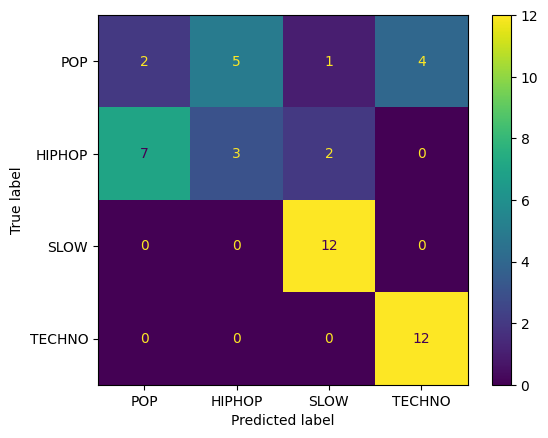

Test Accuracy: 0.6041666666666666
Test F1: 0.559126984126984


In [32]:
eval_pd = test_pd.copy()
eval_pd['preds'] = preds_test
eval_pd = eval_pd.groupby(['subject_id','label','genre_coded'])['preds'].agg(list).reset_index()
eval_pd['pred_final'] = eval_pd['preds'].apply(lambda x: max(set(x), key = x.count))

conf_mat = confusion_matrix(eval_pd['genre_coded'],eval_pd['pred_final'])



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"Test Accuracy: {accuracy_score(eval_pd['genre_coded'],eval_pd['pred_final'])}")
print(f"Test F1: {f1_score(eval_pd['genre_coded'],eval_pd['pred_final'],average='weighted')}")